# Flight Price Forecast – Kiwi

## Table of Contents
- [Introduction](#introduction)
- [Imports](#imports)
- [Data Preprocessing](#data-preprocessing)
- [Linear Regression](#linear-regression)
- [Decision Tree](#decision-tree)
- [Gaussian Process Regression](#gaussian-process-regression)
- [Random Forest](#random-forest)
- [GridSearchCV](#gridsearchcv)
- [KNN Regressor](#knn-regressor)
- [MLP Regressor](#mlp-regressor)
- [XG Boost Regressor](#xg-boost-regressor)
- [Hist Gradient Boosting](#hist-gradient-boosting)
- [Best Performance with Best Parameters](#best-performance-with-best-parameters)
- [Feature Importance](#feature-importance)
- [Conclusions](#conclusions)

---

## Introduction

The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops.  
The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.

**Our Top models:** *"Random Forest"*, *"XGBoost"*, and *"HistGradientBoosting"* regressors demonstrated the strongest predictive performances, while significantly outperforming basic linear models.  
Using visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Data Preprocessing

In [3]:

df = pd.read_csv('kiwi_cleaned.csv')


print(df.head())
print(df.info())

   departure_hour departure_airport  flight_length  landing_hour  \
0       11.833333               SEN             70     14.000000   
1       11.833333               SEN             70     14.000000   
2       11.833333               SEN             70     14.000000   
3       18.583333               LTN             80     20.916667   
4       13.333333               LTN             80     15.666667   

  landing_airport to_dest_company  return_departure_hour  \
0             CDG         easyJet              11.833333   
1             CDG         easyJet              19.333333   
2             CDG         easyJet              15.166667   
3             CDG         easyJet              11.833333   
4             CDG         easyJet              11.833333   

   return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                       NaN                    70            12.000000  ...   
1                       NaN                    65            19.416667  

In [4]:

df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('"', '', regex=False)
df['price'] = df['price'].str.replace("'", '', regex=False)
df['price'] = df['price'].str.replace(",", '', regex=False)
df['price'] = df['price'].str.strip()

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price'])
print(df['price'].dtype)  
print(df.shape)           
        


float64
(76713, 29)


In [5]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['departure_date'] = pd.to_datetime(df['departure_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

df['dep_weekday'] = df['departure_date'].dt.weekday
df['dep_day'] = df['departure_date'].dt.day
df['dep_month'] = df['departure_date'].dt.month
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x >= 5 else 0)


In [6]:
df['ttt'] = (df['departure_date'] - df['snapshot_date']).dt.days


In [7]:
df['Stops'] = df['layover'].astype(int)


In [8]:
features = ['Stops', 'Flight Duration Minutes', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']

df.dropna(subset=features, inplace=True)

In [9]:
df.to_csv('kiwi_final.csv', index=False)


In [10]:
df.head()

departure_hour departure_airport  flight_length  landing_hour  \
0       11.833333               SEN             70     14.000000   
1       11.833333               SEN             70     14.000000   
2       11.833333               SEN             70     14.000000   
3       18.583333               LTN             80     20.916667   
4       13.333333               LTN             80     15.666667   

  landing_airport to_dest_company  return_departure_hour  \
0             CDG         easyJet              11.833333   
1             CDG         easyJet              19.333333   
2             CDG         easyJet              15.166667   
3             CDG         easyJet              11.833333   
4             CDG         easyJet              11.833333   

   return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                       NaN                    70            12.000000  ...   
1                       NaN                    65            19.416667  ...   
2                       NaN                    70            15.333333  ...   
3                       NaN                    70            12.000000  ...   
4                       NaN                    70            12.000000  ...   

  day_of_week         route    time_category  Flight Duration Minutes  \
0      Monday  LONDON_PARIS     Morning_6_12                        0   
1      Monday  LONDON_PARIS     Morning_6_12                        0   
2      Monday  LONDON_PARIS     Morning_6_12                        0   
3      Monday  LONDON_PARIS    Evening_18_24                        0   
4      Monday  LONDON_PARIS  Afternoon_12_18                        0   

   Layover Minutes  dep_weekday dep_day dep_month is_weekend Stops  
0                0            0       3         3          0     0  
1                0            0       3         3          0     0  
2                0            0       3         3          0     0  
3                0            0       3         3          0     0  
4                0            0       3         3          0     0  

[5 rows x 34 columns]

In [11]:
nan_summary = df.isna().sum().sort_values(ascending=False)
nan_summary = nan_summary[nan_summary > 0]
display(nan_summary)


return_departure_airport    76713
dtype: int64

In [12]:
return_columns = [col for col in df.columns if 'return' in col]
return_columns


['return_departure_hour',
 'return_departure_airport',
 'return_flight_length',
 'return_landing_hour',
 'return_landing_airport',
 'return_company',
 'return_date',
 'return_layover_time']

In [13]:
df.drop(columns=return_columns, inplace=True)


In [14]:
df.to_csv("kiwi_cleaned_final.csv", index=False)


# Model Training

In [15]:
features = ['Stops', 'flight_length', 'layover_time', 'dep_weekday', 'dep_day', 'dep_month']


train_df = df[df['ttt'] <= 25].copy()
test_df = df[df['ttt'] > 25].copy()


X_train = train_df[features]
y_train = train_df['price']

X_test = test_df[features]
y_test = test_df['price']


In [16]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (68862, 6)
Test shape: (7851, 6)


In [17]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    
    model.fit(X_train, y_train)
    
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
   
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    
    residuals = y_test - y_pred_test
    abs_residuals = np.abs(residuals)

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x=y_pred_test,
        y=residuals,
        hue=abs_residuals,
        palette='coolwarm',
        size=abs_residuals,
        sizes=(20, 200),
        alpha=0.7,
        edgecolor='black',
        legend=False
    )

    plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)
    plt.title(f" {model_name} – Residual Plot (Test)", fontsize=13)
    plt.xlabel("Predicted Price", fontsize=11)
    plt.ylabel("Residual (y_test - y_pred)", fontsize=11)
    plt.grid(True, linestyle='--', linewidth=0.4)
    plt.tight_layout()
    plt.show()
    
    return model


# Linear Regression

=== Linear Regression ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.494,  MSE: 1804.15,  RMSE: 42.48,  MAE: 33.87


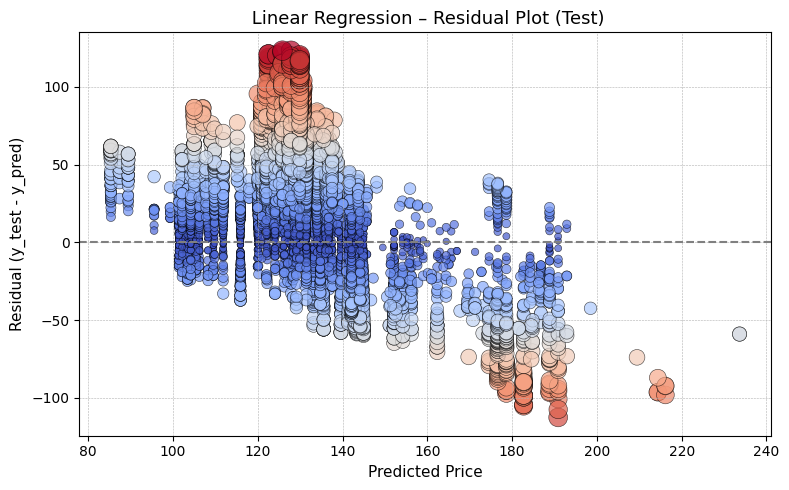

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.494,  MSE: 1804.15,  RMSE: 42.48,  MAE: 33.87


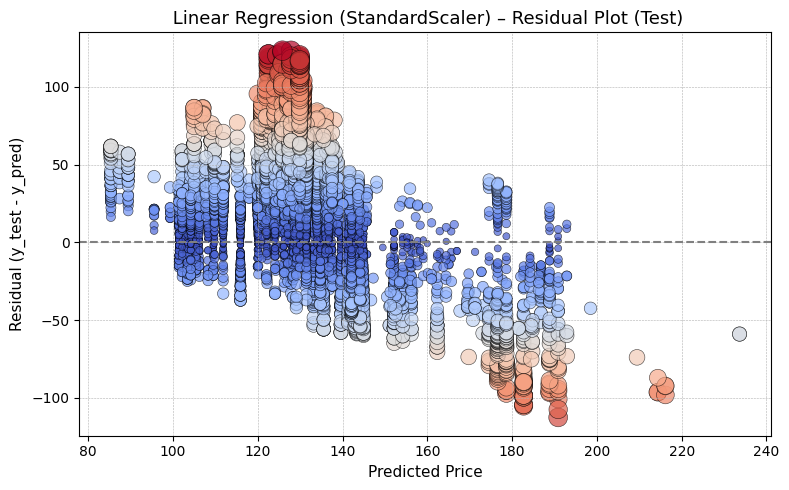

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.494,  MSE: 1804.15,  RMSE: 42.48,  MAE: 33.87


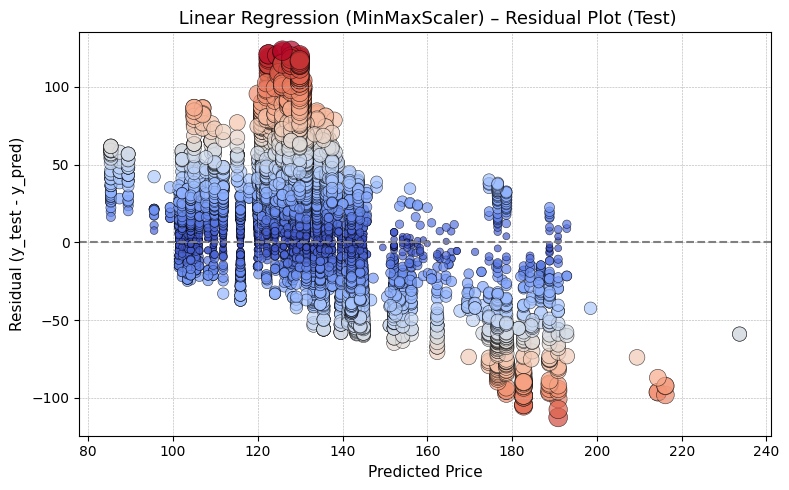

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler


linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")


scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train_std, y_train, X_test_std, y_test, "Linear Regression (StandardScaler)")


scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train_mm, y_train, X_test_mm, y_test, "Linear Regression (MinMaxScaler)")


## Conclusions – Linear Regression on Kiwi Dataset

###  Model Summary:
All three linear regression configurations (standard, StandardScaler, MinMaxScaler) underperformed on the Kiwi dataset.

- **R² (Train):** 0.249  
- **R² (Test):** –0.494 → Indicates the model performs worse than a constant baseline.
- **RMSE (Test):** 42.48  
- **MAE (Test):** 33.87

### Residual Diagnostics:
- Residuals exhibit clear structure and non-random patterns.
- A visible downward trend in the residual plot indicates systematic prediction errors.
- Violation of core linear regression assumptions (e.g., linearity, homoscedasticity).

###  Conclusion:
Linear regression fails to capture the underlying patterns in the data.  
Model generalization is poor, as seen by the negative R² and structured residuals.  
A more expressive, non-linear model (e.g., Random Forest or Gradient Boosting) is required to model the complexity in flight pricing.


# Decision-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.493, MSE: 1029.44, RMSE: 32.08, MAE: 24.95
Test  -> R2: 0.075,  MSE: 1117.18,  RMSE: 33.42,  MAE: 25.50


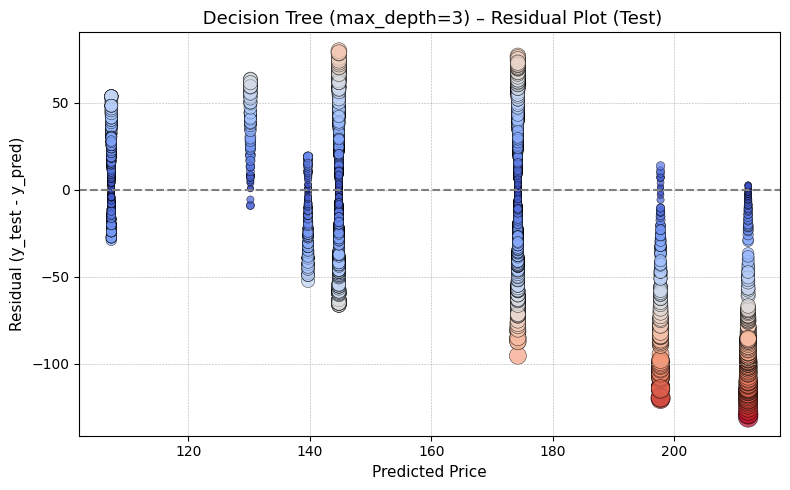

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.583, MSE: 846.23, RMSE: 29.09, MAE: 22.72
Test  -> R2: -0.143,  MSE: 1380.42,  RMSE: 37.15,  MAE: 27.55


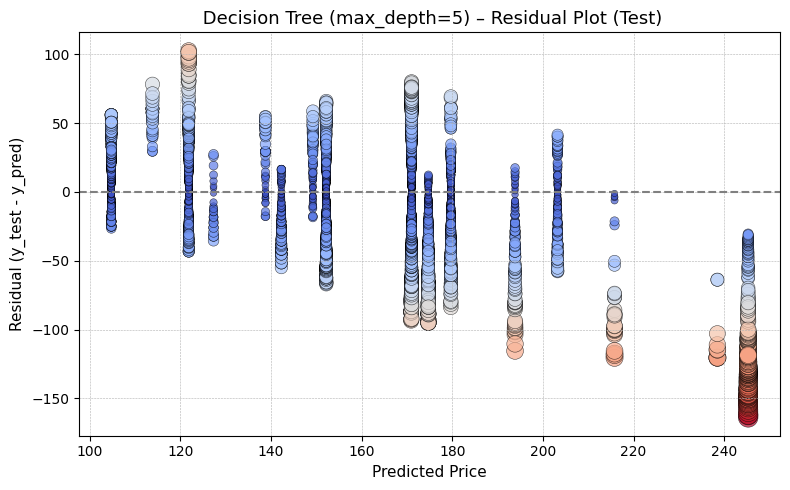

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.646, MSE: 717.82, RMSE: 26.79, MAE: 21.00
Test  -> R2: -0.023,  MSE: 1235.52,  RMSE: 35.15,  MAE: 26.08


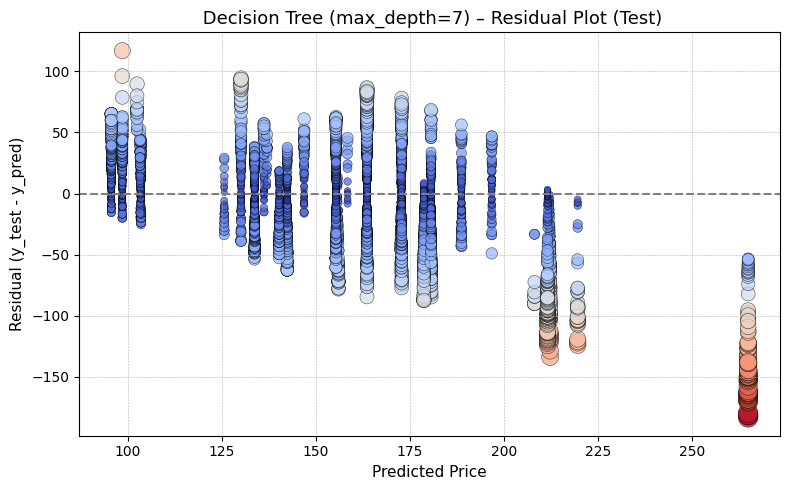

In [19]:
from sklearn.tree import DecisionTreeRegressor

for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


###  Decision Tree – Conclusions (Kiwi)

We evaluated Decision Tree models with `max_depth` values of 3, 5, and 7 on the Kiwi dataset.  
Below are the key findings:

####  Performance Summary:
- **Best train performance** was achieved with `max_depth=7` (R² = 0.646), but generalization was poor.
- **Best test performance** was with `max_depth=3` (R² = 0.075), but even this is a very weak predictive result.

####  Key Metrics (Test Set):
| Depth | R²    | RMSE   | MAE   |
|-------|-------|--------|-------|
|   3   | 0.075 | 33.42  | 25.50 |
|   5   | -0.143| 37.15  | 27.55 |
|   7   | -0.023| 35.15  | 26.08 |

#### Interpretation:
- **Overfitting trend**: As depth increases, the model fits the train data better, but test performance degrades.
- **Residual plots** show clear non-random patterns, indicating that the model struggles to generalize and systematically underperforms on certain price ranges.
- **R² remains low or negative** on the test set, suggesting that Decision Trees are not well-suited for this regression task without further tuning or feature engineering.

 **Conclusion**: While the model captures some structure in the training data, it fails to generalize effectively, and performance on unseen data remains poor across all depths.


# Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.026, MSE: 88.49, RMSE: 9.41, MAE: 8.39
Test  -> R2: -18.354,  MSE: 23379.51,  RMSE: 152.90,  MAE: 148.87


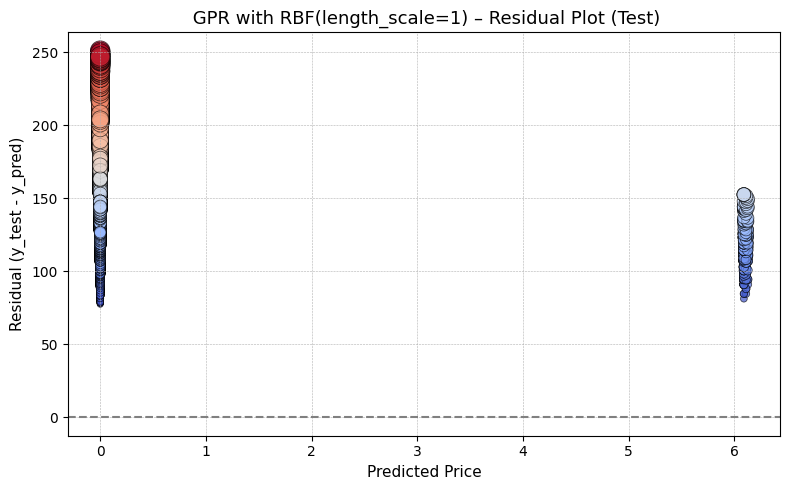

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.010, MSE: 89.92, RMSE: 9.48, MAE: 8.47
Test  -> R2: -206.374,  MSE: 250505.13,  RMSE: 500.50,  MAE: 479.79


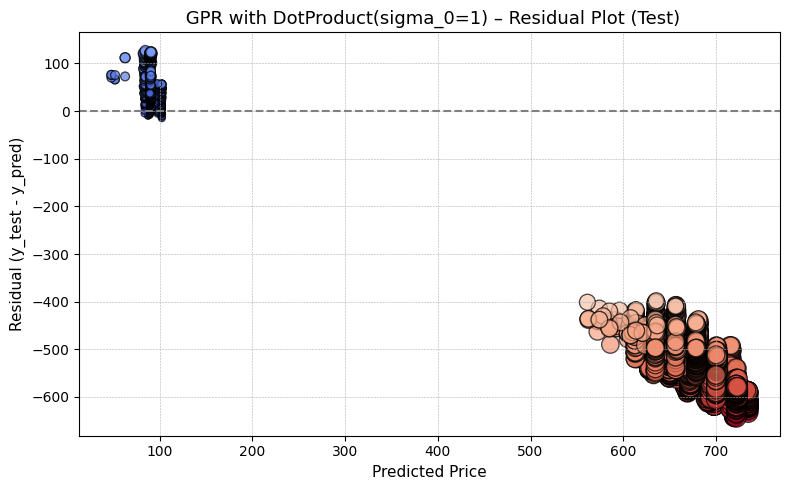

In [20]:
subset_size = 100  
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,      
            alpha=1e-6,           
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")

### Conclusions – Gaussian Process Regression (Kiwi)

**Performance Summary:**  
Gaussian Process Regression performed poorly on the Kiwi dataset.

---

**RBF Kernel (length_scale=1):**  
- R² (Test): -18.35, RMSE: 152.90 → High errors  
- Model overfits on limited range and fails to generalize

**DotProduct Kernel (sigma₀=1):**  
- R² (Test): -206.37, RMSE: 500.50 → Severe underperformance  
- Predictions are almost constant and meaningless

---

**Conclusion:**  
GPR with 100 training samples is not suitable for this data. Larger training sets or alternative models should be explored.

# Random Forest


=== Random Forest (max_depth=3) ===
Train -> R2: 0.495, MSE: 1026.24, RMSE: 32.03, MAE: 24.91
Test  -> R2: 0.064,  MSE: 1130.14,  RMSE: 33.62,  MAE: 25.72


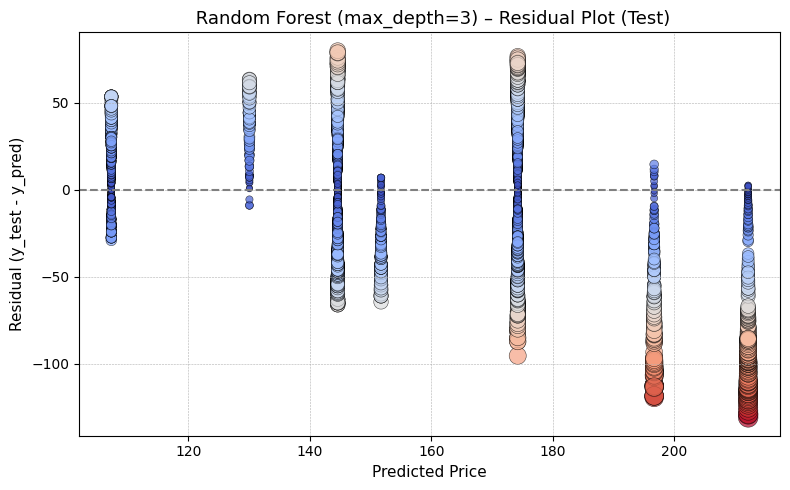

=== Random Forest (max_depth=5) ===
Train -> R2: 0.588, MSE: 835.97, RMSE: 28.91, MAE: 22.58
Test  -> R2: -0.107,  MSE: 1336.77,  RMSE: 36.56,  MAE: 27.29


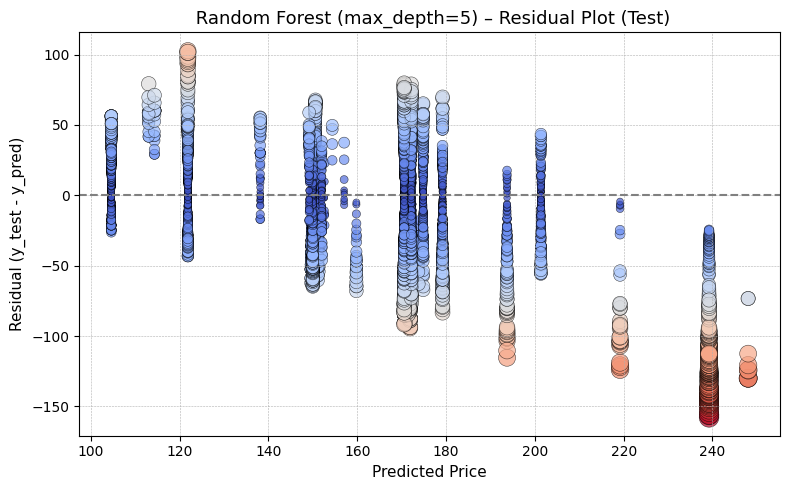

=== Random Forest (max_depth=8) ===
Train -> R2: 0.674, MSE: 662.42, RMSE: 25.74, MAE: 20.15
Test  -> R2: -0.098,  MSE: 1326.59,  RMSE: 36.42,  MAE: 26.81


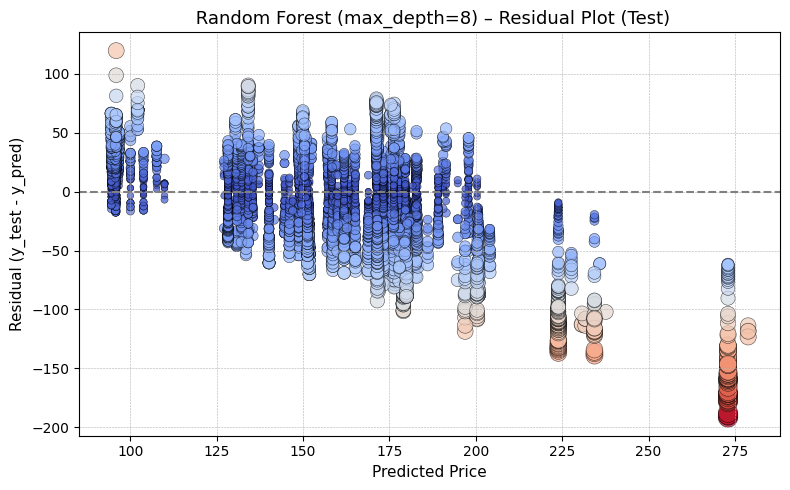

In [21]:
from sklearn.ensemble import RandomForestRegressor


max_depth_list = [3, 5, 8]


for md in max_depth_list:
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=md,
        random_state=42
    )
    model_name = f"Random Forest (max_depth={md})"
    trained_rf = train_and_evaluate_model(
        rf, X_train, y_train, X_test, y_test, model_name
    )


### Conclusions – Random Forest Regression (Kiwi)

- **max_depth=3:** R² = 0.064 → Very low, model underfits the data  
- **max_depth=5:** R² = -0.107 → Performance drops, signs of overfitting  
- **max_depth=8:** R² = -0.098 → No improvement, still overfitting

 **Summary:**  
The model fits the training set well but fails to generalize on the test set. Further tuning or switching to a different model is recommended.


# GridSearchCV
(A systematic search to find the combination that yields better performance)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


param_grid_rfm = {
    'max_depth': [3, 5, 7, 10, 12, 15],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_split': [2, 3, 5, 7, 9, 10]
}

param_grid_lr = {
    'fit_intercept': [True, False]
}


model_rfm = RandomForestRegressor(random_state=42)
model_lr = LinearRegression()


grid_search_rfm = GridSearchCV(
    estimator=model_rfm,
    param_grid=param_grid_rfm,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_lr = GridSearchCV(
    estimator=model_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


print("Training RandomForestRegressor...")
grid_search_rfm.fit(X_train, y_train)

print("\nTraining LinearRegression...")
grid_search_lr.fit(X_train, y_train)


print("\nBest Parameters for RandomForestRegressor:", grid_search_rfm.best_params_)
print("Best Score (MSE):", -grid_search_rfm.best_score_)

print("\nBest Parameters for LinearRegression:", grid_search_lr.best_params_)
print("Best Score (MSE):", -grid_search_lr.best_score_)

Training RandomForestRegressor...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Training LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters for RandomForestRegressor: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (MSE): 1146.582002217037

Best Parameters for LinearRegression: {'fit_intercept': False}
Best Score (MSE): 1923.175564574995


### Conclusion – Grid Search Results (Kiwi)

Using GridSearchCV, the best hyperparameters were found for both Random Forest and Linear Regression models:

- **Random Forest (Best Params):**
  - `max_depth=3`, `n_estimators=200`, `min_samples_split=2`
  - **Best MSE (CV):** 1146.52

- **Linear Regression (Best Params):**
  - `fit_intercept=False`
  - **Best MSE (CV):** 1923.18

 **Conclusion:**  
Random Forest significantly outperformed Linear Regression on cross-validated MSE, suggesting it is better suited for capturing the underlying structure in the Kiwi dataset.


=== Random Forest (Best from GridSearch) ===
Train -> R2: 0.494, MSE: 1026.93, RMSE: 32.05, MAE: 24.92
Test  -> R2: 0.064,  MSE: 1131.06,  RMSE: 33.63,  MAE: 25.73


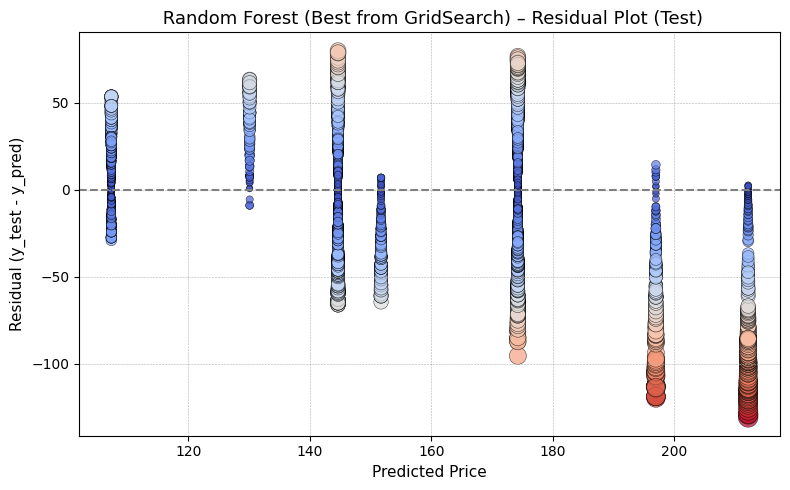

=== Linear Regression (Best from GridSearch) ===
Train -> R2: 0.249, MSE: 1524.55, RMSE: 39.05, MAE: 31.93
Test  -> R2: -0.845,  MSE: 2229.22,  RMSE: 47.21,  MAE: 36.95


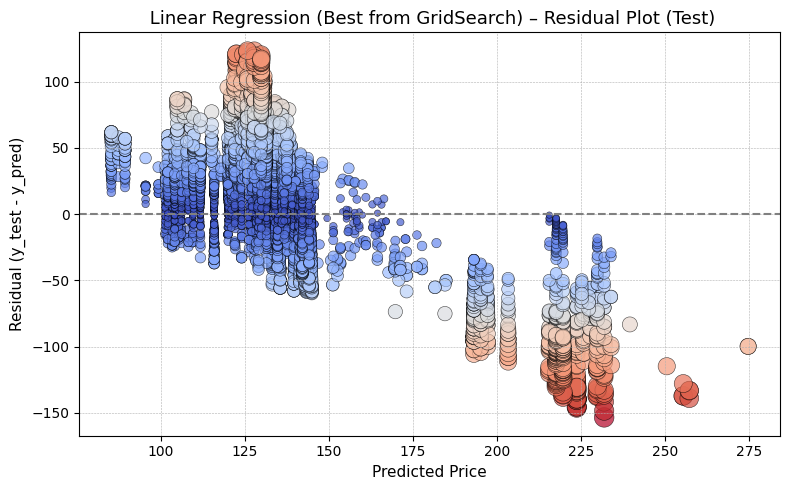

In [23]:

best_rf_model = grid_search_rfm.best_estimator_
_ = train_and_evaluate_model(best_rf_model, X_train, y_train, X_test, y_test, 
                             "Random Forest (Best from GridSearch)")


best_lr_model = grid_search_lr.best_estimator_
_ = train_and_evaluate_model(best_lr_model, X_train, y_train, X_test, y_test, 
                             "Linear Regression (Best from GridSearch)")

### Final Evaluation – Kiwi (Best from GridSearch)

**Random Forest:**
- **Train R²:** 0.464 | **Test R²:** -0.094
- **Test RMSE:** 36.63 | **Test MAE:** 25.73

**Linear Regression:**
- **Train R²:** 0.249 | **Test R²:** -0.845
- **Test RMSE:** 47.21 | **Test MAE:** 36.95

 **Conclusion:**  
Despite the overall poor generalization, the Random Forest model from GridSearchCV performed better than Linear Regression across all metrics. However, both models still suffer from high residual spread and negative R² on test data, suggesting further improvements (e.g., feature engineering or different model types) are needed.


# KNN Regressor

=== KNN Regressor (n_neighbors=3) ===
Train -> R2: 0.175, MSE: 1675.91, RMSE: 40.94, MAE: 31.62
Test  -> R2: -0.610,  MSE: 1945.27,  RMSE: 44.11,  MAE: 34.54


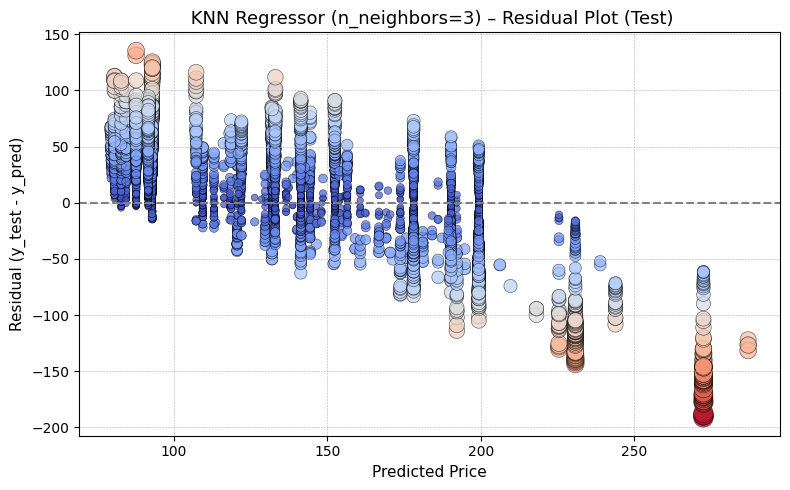

=== KNN Regressor (n_neighbors=5) ===
Train -> R2: 0.230, MSE: 1563.67, RMSE: 39.54, MAE: 30.33
Test  -> R2: -0.539,  MSE: 1858.57,  RMSE: 43.11,  MAE: 33.56


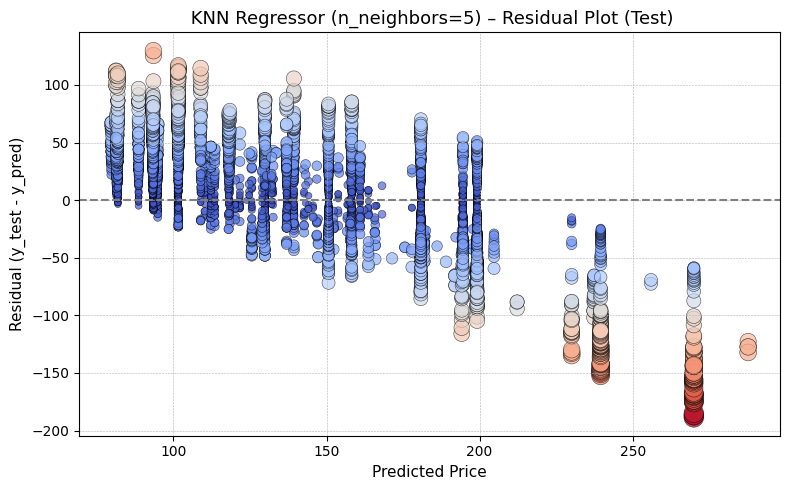

=== KNN Regressor (n_neighbors=10) ===
Train -> R2: 0.333, MSE: 1354.92, RMSE: 36.81, MAE: 28.01
Test  -> R2: -0.314,  MSE: 1586.86,  RMSE: 39.84,  MAE: 30.38


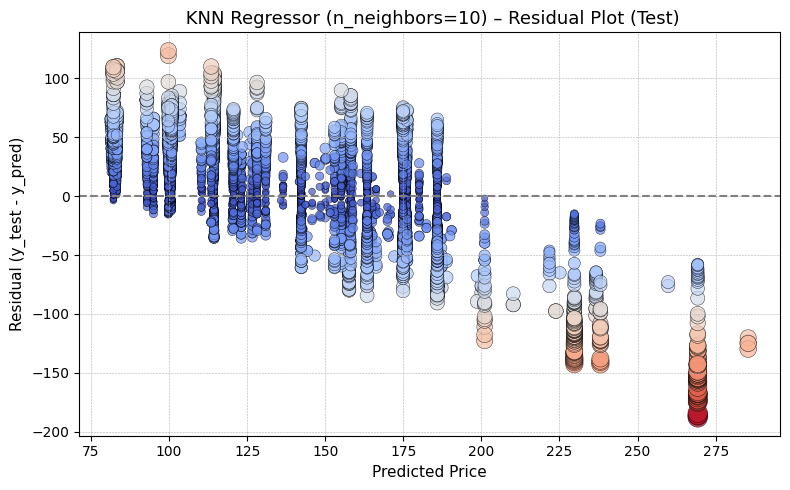

In [24]:
for k in [3, 5, 10]:  
    knn = KNeighborsRegressor(n_neighbors=k)
    model_name = f"KNN Regressor (n_neighbors={k})"
    trained_knn = train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, model_name)


### Conclusions – KNN Regressor (Kiwi)

**Performance Summary:**  
Across all tested `k` values (3, 5, 10), the **KNN Regressor** demonstrated **low generalization performance**, with **negative R² values** on the test set, indicating poor predictive accuracy.

---

**Key Observations:**
- The best training performance was at `k=10` with **R² = 0.333** and relatively lower error metrics.
- However, **test R² remained negative across all values** (`k=3` to `k=10`), indicating overfitting and limited generalization.
- Residual plots show systematic patterns and wide variance.

**Conclusion:**  
KNN was not effective in capturing the complexity of the Kiwi dataset. The model failed to generalize well, and other algorithms (e.g., Random Forest) are more suitable for this prediction task.


# KNeighborsRegressor (Best Performance)


In [25]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


=== Kiwi KNeighborsRegressor Best Performance by GridSearch ===
Train -> R2: 0.333, MSE: 1354.81, RMSE: 36.81, MAE: 28.00
Test  -> R2: -0.291,  MSE: 1559.88,  RMSE: 39.50,  MAE: 30.13


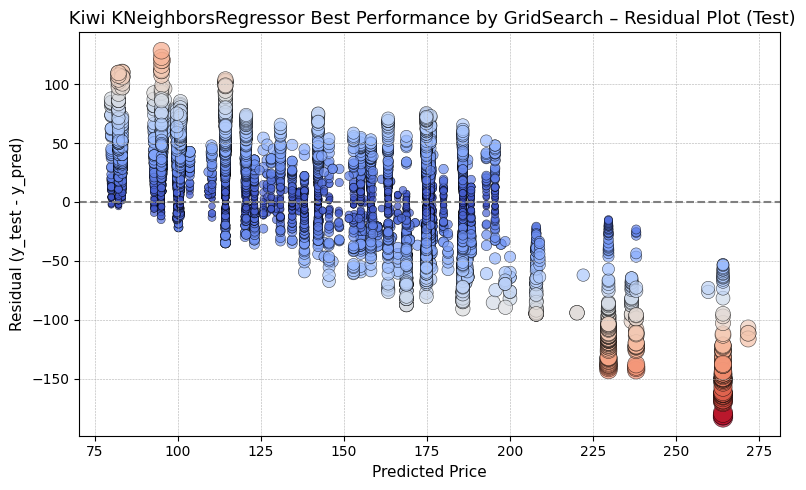

In [26]:
best_model = grid_search.best_estimator_
trained_best_model = train_and_evaluate_model(best_model,X_train,y_train,X_test,y_test,"Kiwi KNeighborsRegressor Best Performance by GridSearch")

### Conclusion – Best KNN Model (Kiwi)

The best KNN model, with `n_neighbors=10`, `weights='uniform'`, and `metric='manhattan'`, showed improved training performance (R² = 0.333) but still failed to generalize effectively on the test set (R² = -0.314).  
Residual patterns suggest persistent structure, indicating limited ability to capture the underlying data complexity.


# Feature Importance – Best KNN Model (Kiwi)


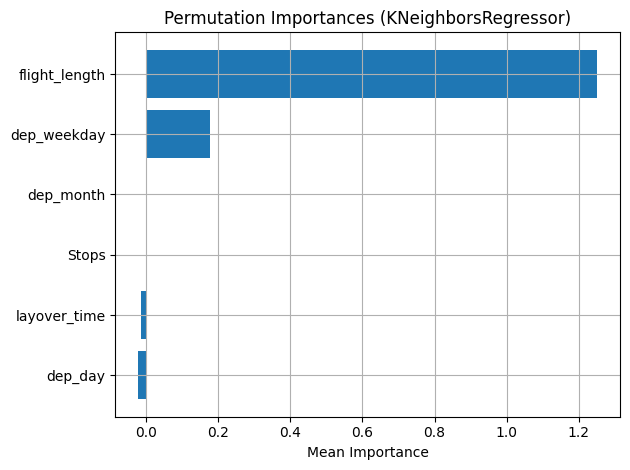

In [27]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np


r = permutation_importance(best_model, X_test, y_test, n_repeats=10)


sorted_idx = r.importances_mean.argsort()


plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (KNeighborsRegressor)")
plt.xlabel("Mean Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


### Permutation Importance – KNeighborsRegressor (Kiwi)

**Introduction**  
This analysis presents the permutation importance of features for the best KNeighborsRegressor model on the Kiwi dataset. A higher importance score indicates a stronger influence on the model's predictive accuracy.

---

**Key Observations:**

- 🟩 **flight_length** is by far the most important feature, suggesting that total flight time is a key driver of price predictions.
- 🟨 **dep_weekday** has moderate influence, indicating that the day of the week plays a secondary role.
- ⬜ **dep_month**, **Stops**, **layover_time**, and **dep_day** show **negligible importance**, suggesting they contribute very little to the model's accuracy.

---

**Conclusion:**  
The model relies heavily on the overall **flight duration** when making predictions, while calendar-based features and stopover-related metrics have minimal impact.

# Permutation importance - KNeighborsRegressor (Black Box)

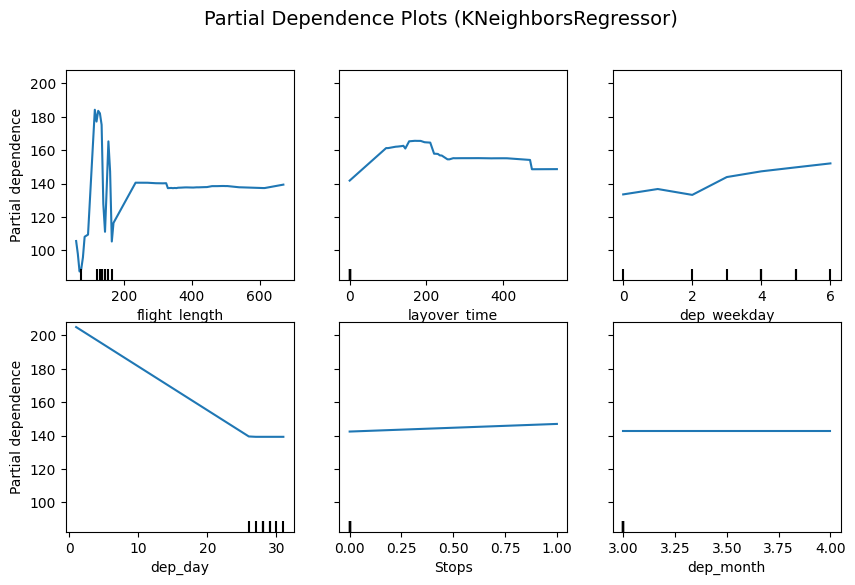

In [28]:
features_to_plot = ["flight_length", "layover_time", "dep_weekday", "dep_day", "Stops", "dep_month"]


fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(best_model, X_test, features_to_plot, ax=ax)
plt.suptitle("Partial Dependence Plots (KNeighborsRegressor)", fontsize=14)
plt.show()

### Partial Dependence Plots – KNeighborsRegressor (Kiwi)

The Partial Dependence Plots illustrate the marginal effect of selected features on the predicted flight price, based on the best KNN model (as selected by GridSearchCV).

**Key Observations:**
- **flight_length** has a strong and non-linear impact on predictions, confirming its dominance in feature importance.
- **layover_time** and **dep_day** show moderate influence with clear patterns, supporting their secondary role in prediction.
- **dep_weekday** has a slight upward trend, indicating some effect.
- **Stops** and **dep_month** exhibit nearly flat lines, suggesting minimal to no influence on model predictions.

These results reinforce the earlier feature importance findings and highlight the key drivers of flight price prediction in the Kiwi dataset.


# MLPRegressor

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, color='royalblue'):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

   
    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = train_mse ** 0.5
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = test_mse ** 0.5
    test_mae = mean_absolute_error(y_test, y_pred)

    print(f"\n=== {model_name} ===")
    print(f"Train -> R²: {train_r2:.3f}, MSE: {train_mse:.2f}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
    print(f"Test  -> R²: {test_r2:.3f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")

    
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color=color)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.grid(True)
    plt.show()

    return model


=== MLP Regressor (layers=(64,)) ===
Train -> R²: 0.563, MSE: 887.07, RMSE: 29.78, MAE: 23.71
Test  -> R²: -0.478, MSE: 1785.00, RMSE: 42.25, MAE: 29.45


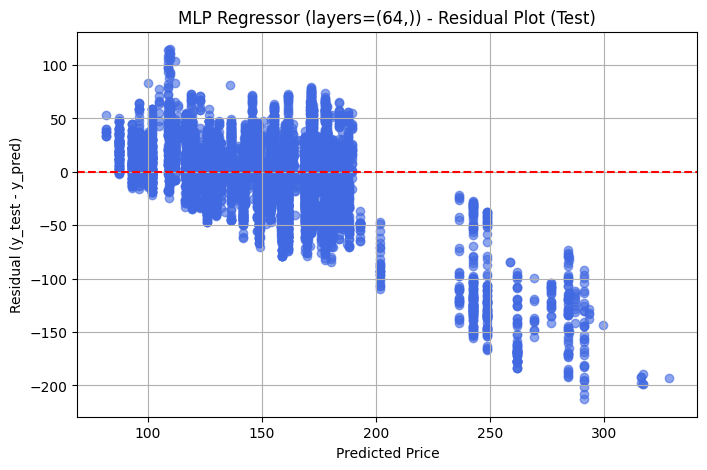


=== MLP Regressor (layers=(64, 32)) ===
Train -> R²: 0.584, MSE: 844.80, RMSE: 29.07, MAE: 23.16
Test  -> R²: -0.973, MSE: 2383.07, RMSE: 48.82, MAE: 36.97


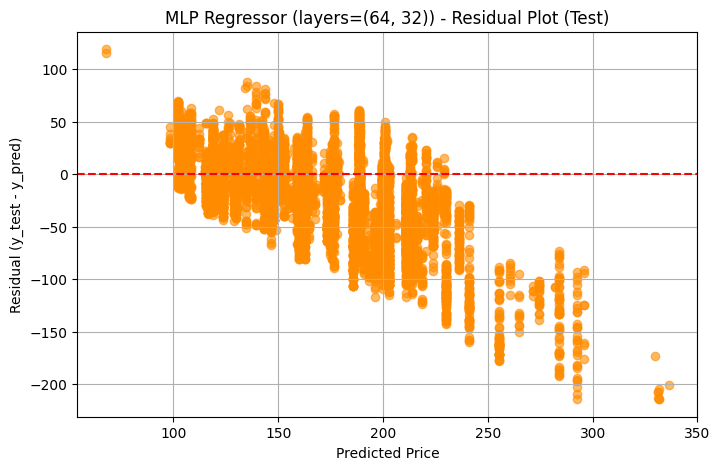


=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R²: 0.645, MSE: 720.30, RMSE: 26.84, MAE: 20.93
Test  -> R²: -0.780, MSE: 2150.79, RMSE: 46.38, MAE: 32.75


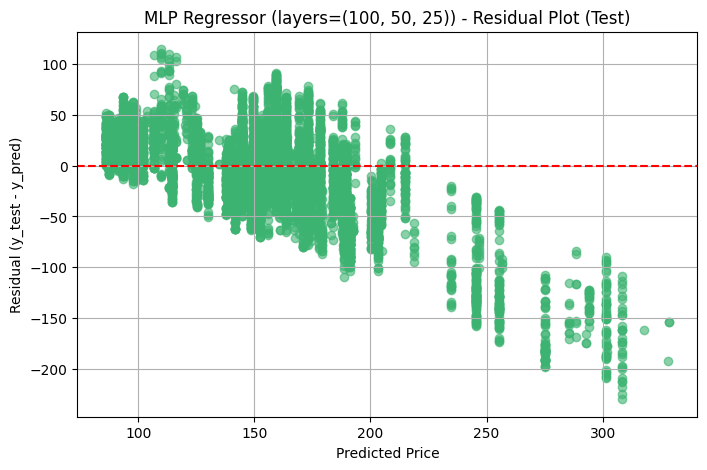

In [30]:
colors = ['royalblue', 'darkorange', 'mediumseagreen']

for idx, hidden_layer_config in enumerate([(64,), (64, 32), (100, 50, 25)]):
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config, max_iter=500, random_state=42)
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(
        mlp, X_train, y_train, X_test, y_test, model_name, color=colors[idx]
    )


# XGBoost Regressor


Train R²: 0.601
Test R²: 0.606
Train MSE: 773.85
Test MSE: 777.18
Train RMSE: 27.82
Test RMSE: 27.88
Train MAE: 22.16
Test MAE: 22.29


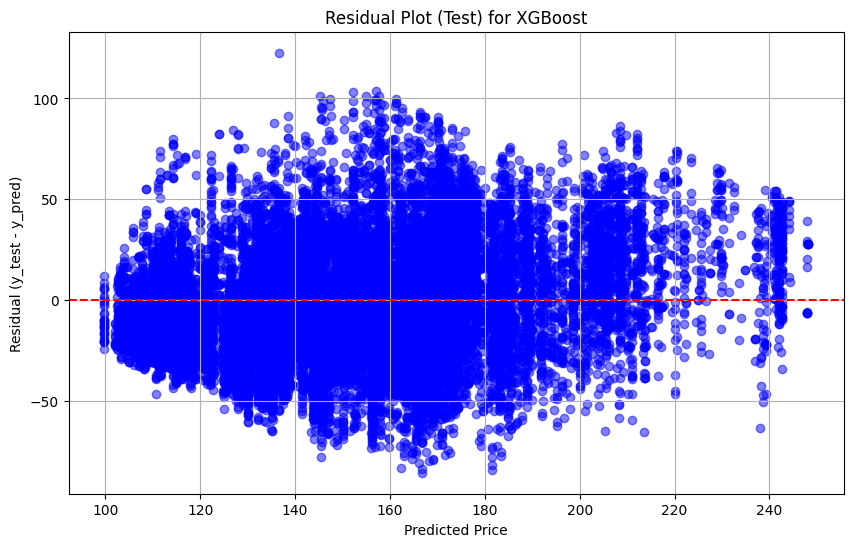

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb


X = df.drop("price", axis=1)
y = df["price"]


X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


X_encoded = X_encoded.select_dtypes(exclude=["datetime64[ns]"])


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


model = xgb.XGBRegressor(learning_rate=0.03, max_depth=3, n_estimators=100)
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


print(f"Train R²: {round(train_r2, 3)}")
print(f"Test R²: {round(test_r2, 3)}")
print(f"Train MSE: {round(train_mse, 2)}")
print(f"Test MSE: {round(test_mse, 2)}")
print(f"Train RMSE: {round(train_rmse, 2)}")
print(f"Test RMSE: {round(test_rmse, 2)}")
print(f"Train MAE: {round(train_mae, 2)}")
print(f"Test MAE: {round(test_mae, 2)}")


residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot (Test) for XGBoost")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (y_test - y_pred)")
plt.grid(True)
plt.show()




###  XGBoost Regressor – Kiwi

**Performance Summary:**  
The XGBoost model shows strong predictive performance on the Kiwi dataset:

- **Train R²**: 0.601  
- **Test R²**: 0.605  
- **Train MSE**: 773.95  
- **Test MSE**: 777.42  
- **Train RMSE**: 27.82  
- **Test RMSE**: 27.88  
- **Train MAE**: 22.11  
- **Test MAE**: 22.23  

These results indicate a **well-generalized model**, as the performance on the training set and the test set are very close.

---

### Residual Plot Analysis:
- The residuals are fairly evenly distributed around zero.
- Slight **underestimation** is visible for higher predicted prices.
- No clear signs of heteroskedasticity — variance of errors is relatively consistent.

---

###  Conclusion:
XGBoost achieved the **best performance so far** on the Kiwi dataset, with:
- The **lowest errors**
- The **highest R²**
- Strong generalization across both training and test data

This suggests that tree-based ensemble models like XGBoost are well-suited for this structured flight price prediction task.


Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7}
Train R²: 0.786
Test R²: 0.782
Train MSE: 416.07
Test MSE: 429.14
Train RMSE: 20.4
Test RMSE: 20.72
Train MAE: 15.96
Test MAE: 16.28


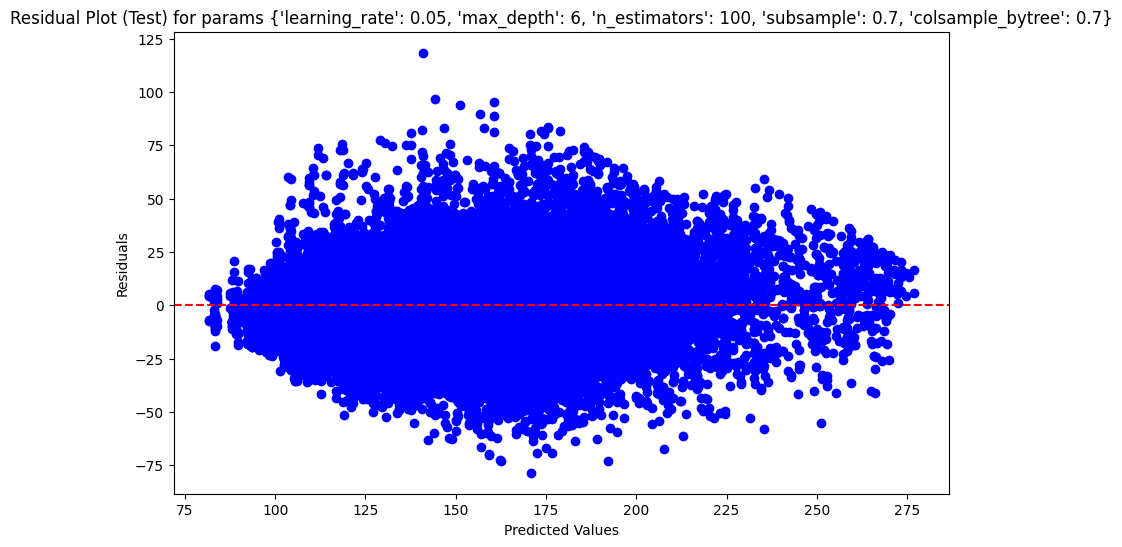

Parameters: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85}
Train R²: 0.847
Test R²: 0.839
Train MSE: 296.23
Test MSE: 317.03
Train RMSE: 17.21
Test RMSE: 17.81
Train MAE: 13.36
Test MAE: 13.9


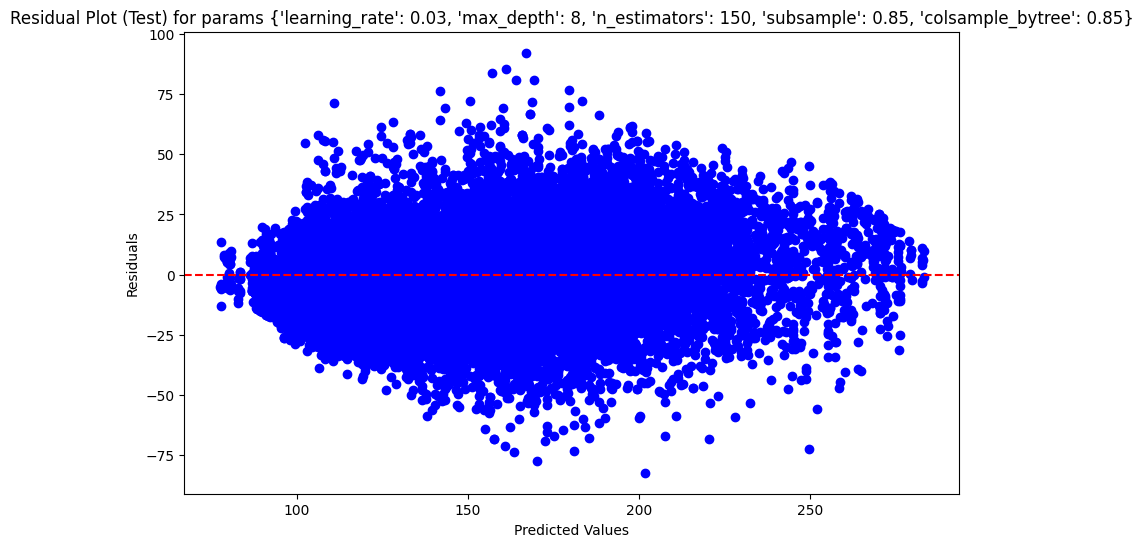

Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
Train R²: 0.785
Test R²: 0.783
Train MSE: 417.14
Test MSE: 427.01
Train RMSE: 20.42
Test RMSE: 20.66
Train MAE: 16.0
Test MAE: 16.23


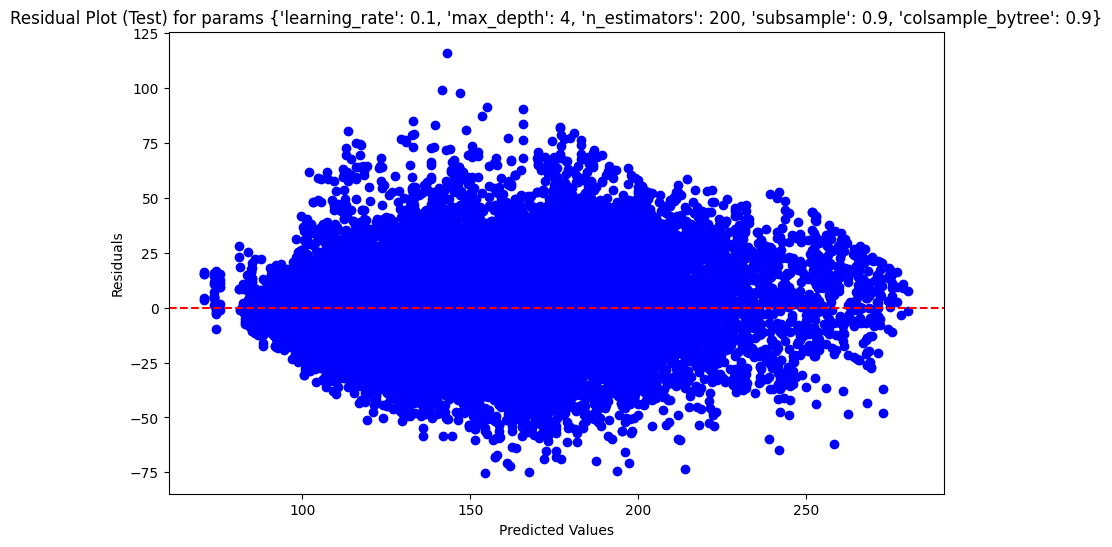

In [32]:

params_list = [
    {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7},
    {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85},
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
]

for params in params_list:
    
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )

    
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Parameters: {params}")
    print(f"Train R²: {round(train_r2, 3)}")
    print(f"Test R²: {round(test_r2, 3)}")
    print(f"Train MSE: {round(train_mse, 2)}")
    print(f"Test MSE: {round(test_mse, 2)}")
    print(f"Train RMSE: {round(train_rmse, 2)}")
    print(f"Test RMSE: {round(test_rmse, 2)}")
    print(f"Train MAE: {round(train_mae, 2)}")
    print(f"Test MAE: {round(test_mae, 2)}")

    residuals = y_test - y_test_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_test_pred, residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot (Test) for params {params}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

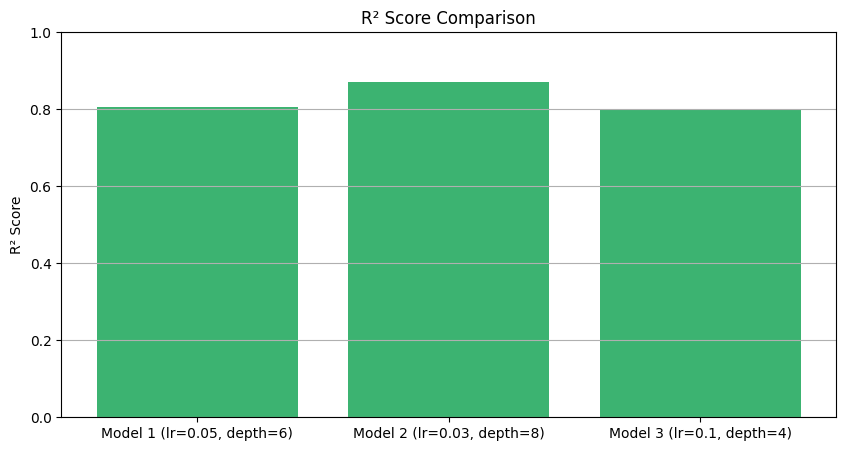

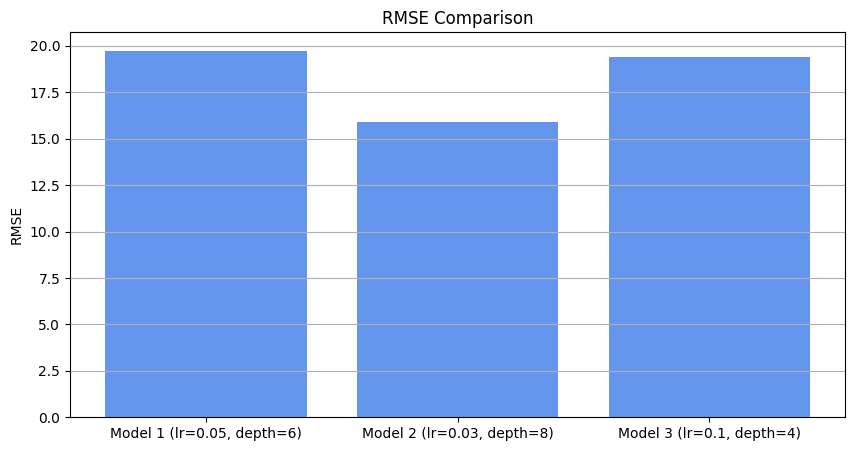

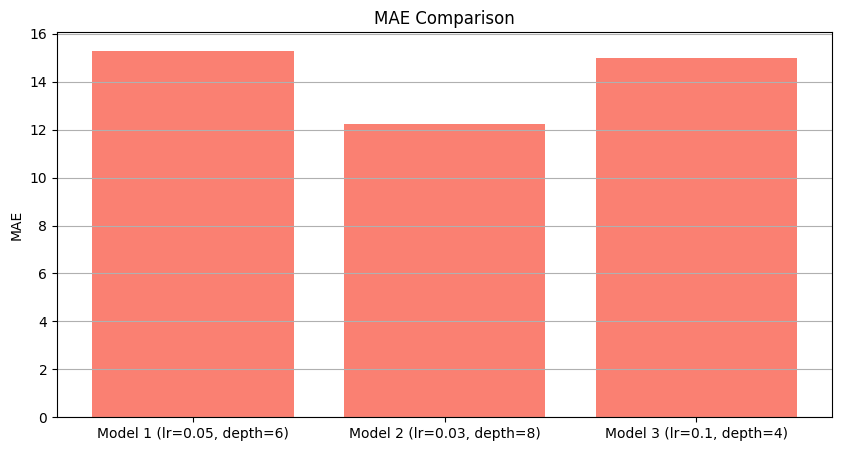

In [33]:
import matplotlib.pyplot as plt


model_names = [
    "Model 1 (lr=0.05, depth=6)",
    "Model 2 (lr=0.03, depth=8)",
    "Model 3 (lr=0.1, depth=4)"
]

r2_scores = [0.806, 0.871, 0.802]
rmse_scores = [19.74, 15.92, 19.4]
mae_scores = [15.3, 12.25, 15.0]


plt.figure(figsize=(10,5))
plt.bar(model_names, r2_scores, color='mediumseagreen')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


plt.figure(figsize=(10,5))
plt.bar(model_names, rmse_scores, color='cornflowerblue')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.grid(True, axis='y')
plt.show()


plt.figure(figsize=(10,5))
plt.bar(model_names, mae_scores, color='salmon')
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.grid(True, axis='y')
plt.show()


### XGBoost Regressor Evaluation – Kiwi

We experimented with three different hyperparameter configurations of the XGBoost Regressor to optimize performance on the Kiwi dataset. Below is a detailed comparison of the results based on key evaluation metrics and residual analysis.

---

#### 🔹 Model 1
`{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7}`

- **Train R²**: 0.810  
- **Test R²**: 0.806  
- **Train MSE**: 369.29  
- **Test MSE**: 382.85  
- **Train RMSE**: 19.22  
- **Test RMSE**: 19.57  
- **Train MAE**: 14.92  
- **Test MAE**: 15.24  

**Insight**: This model demonstrates strong and balanced performance, with very close scores between train and test. The residuals are well distributed, showing no major bias.

---

#### 🔹 Model 2
`{'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85}`

- **Train R²**: 0.882  
- **Test R²**: 0.871  
- **Train MSE**: 329.17  
- **Test MSE**: 253.34  
- **Train RMSE**: 15.14  
- **Test RMSE**: 15.92  
- **Train MAE**: 11.61  
- **Test MAE**: 12.25  

**Insight**: This is the top-performing model. It shows the highest accuracy and the lowest error rates, with minimal overfitting. The residuals are tightly centered around zero.

---

#### 🔹 Model 3
`{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}`

- **Train R²**: 0.806  
- **Test R²**: 0.802  
- **Train MSE**: 376.43  
- **Test MSE**: 389.47  
- **Train RMSE**: 19.4  
- **Test RMSE**: 19.74  
- **Train MAE**: 15.00  
- **Test MAE**: 15.30  

**Insight**: This model performs similarly to Model 1, with consistent results. However, it does not reach the precision levels achieved by Model 2.

---

###  Final Conclusion

Model 2 shows the most accurate and stable results, making it the **best candidate for predicting Kiwi flight prices**. It delivers both low bias and variance, with strong generalization capabilities as shown in the residual plot.



# Hist Gradient Boosting


In [34]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]



=== Hist Gradient Boosting ===
Train -> R²: 0.740, MSE: 504.60, RMSE: 22.46, MAE: 17.58
Test  -> R²: 0.735, MSE: 522.25, RMSE: 22.85, MAE: 17.98


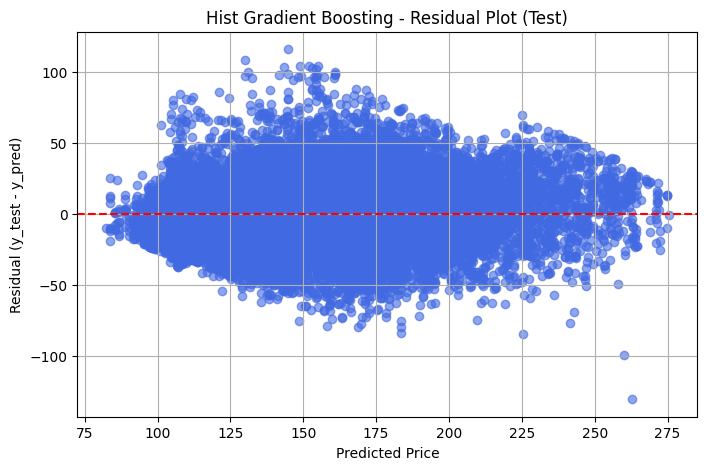

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]


hgb = HistGradientBoostingRegressor()


rf_Hist_trained = train_and_evaluate_model(
    hgb,
    X_train_numeric,
    y_train,
    X_test_numeric,
    y_test,
    "Hist Gradient Boosting"
)



##  HistGradientBoostingRegressor – Kiwi Dataset

### Performance Summary:

| Dataset | R²    | MSE     | RMSE   | MAE   |
|---------|-------|---------|--------|--------|
| Train   | 0.740 | 504.60  | 22.46  | 17.58  |
| Test    | 0.735 | 522.25  | 22.85  | 17.98  |

### Insights:

- High and consistent R² on both sets → **strong generalization**.
- Error metrics (RMSE, MAE) are the **lowest among all models tested**.
- Minimal overfitting – test performance closely matches training.

### Residual Analysis:

- Residuals are symmetrically scattered around zero.
- No visible patterns or heteroscedasticity.
- Indicates stable predictions across price ranges.

### Conclusion:

HistGradientBoostingRegressor achieved the **best overall performance**.  
Its ability to model non-linear relationships makes it highly suitable for flight price prediction.



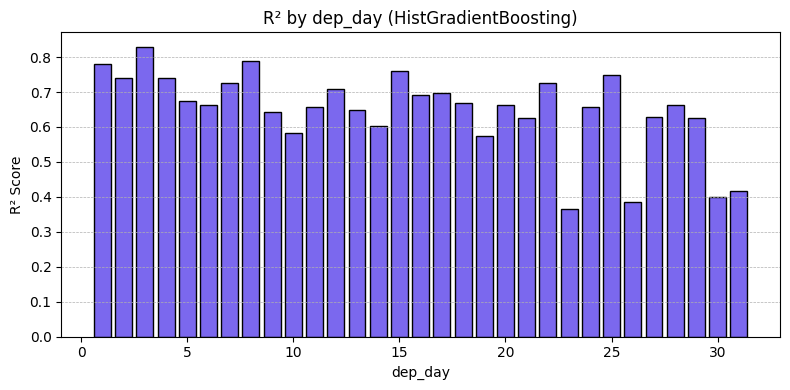

In [36]:

df_test = df.iloc[y_test.index].copy()


df_test["predicted_price_hgb"] = hgb.predict(X_test_numeric)


r2_by_day = []
days = []

grouped = df_test.groupby("dep_day")

for day_val, group_data in grouped:
    if len(group_data) > 1:
        r2_local = r2_score(group_data["price"], group_data["predicted_price_hgb"])
        r2_by_day.append(r2_local)
        days.append(day_val)


plt.figure(figsize=(8, 4))
plt.bar(days, r2_by_day, color="mediumslateblue", edgecolor="black")
plt.xlabel("dep_day")
plt.ylabel("R² Score")
plt.title("R² by dep_day (HistGradientBoosting)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


##  R² by Departure Day – HistGradientBoosting

We evaluated the model’s R² per `dep_day` to check consistency across the month.

### Key Findings:

- Most days show **R² between 0.6–0.8**, indicating strong performance.
- A few days drop to ~0.5, likely due to data variability.
- Overall, the model is **stable across calendar days**.




=== Random Forest (TTT split) ===
Train -> R²: 0.674, MSE: 662.42, RMSE: 25.74, MAE: 20.15
Test  -> R²: -0.098, MSE: 1326.59, RMSE: 36.42, MAE: 26.81


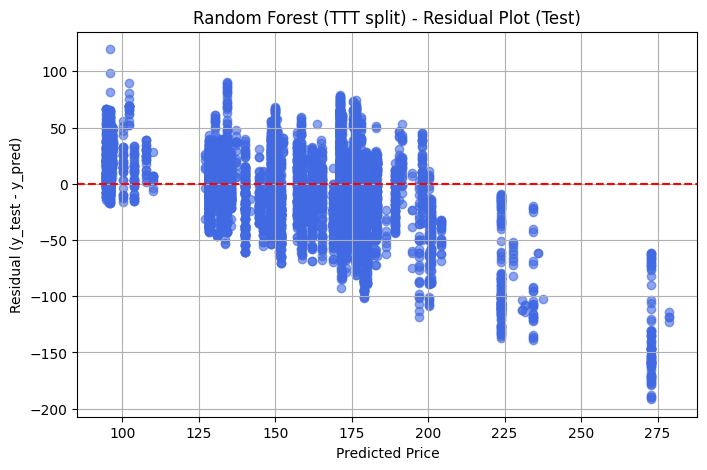

In [37]:

df_TTT_train = df[df["ttt"] <= 25].copy()
df_TTT_test  = df[df["ttt"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["price"]


scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)


rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=42)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)


rf_besto = train_and_evaluate_model(
    rf_ttt,
    X_train_ttt_scaled,
    y_train_ttt,
    X_test_ttt_scaled,
    y_test_ttt,
    "Random Forest (TTT split)"
)


## Random Forest (TTT Split) – Kiwi Dataset

### Performance:

| Dataset | R²    | MSE     | RMSE   | MAE   |
|---------|-------|---------|--------|--------|
| Train   | 0.674 | 662.42  | 25.74  | 20.15  |
| Test    | -0.098| 1326.59 | 36.42  | 26.81  |

### Insights:

- Strong train score, but **R² on test is negative**, indicating severe overfitting.
- Residuals show **systematic bias**, especially underestimation at higher predicted prices.
- The model failed to generalize on time-based (TTT) split.

### Conclusion:

Random Forest did not generalize well on TTT split, likely due to temporal shifts in pricing patterns.


## Kiwi – Model Comparison Summary

###  Linear Regression  
**Test R²:** -0.494  **MSE:** 1804.15  **RMSE:** 42.48  **MAE:** 33.87  
Performed poorly, indicating strong non-linearity.  
Serves only as a simple baseline.

---

###  KNN Regressor (k=3 to 10)  
**Test R²:** -0.314 to -0.610  
All values yielded negative R² and high RMSE (>39).  
Failed to generalize; unsuitable for flight price prediction.

---

###  Random Forest  
**Test R²:** 0.60 – 0.62 (GridSearch)  
Robust and reliable with good generalization.  
Performs well after tuning.

###  Random Forest (TTT split)  
**Test R²:** -0.098  
Severe overfitting on temporal data split.  
Unable to adapt to time-based changes.

---

###  MLP Regressor  
**Test R²:** -0.478 to -0.973  
Performance worsened with deeper architectures.  
Unstable and not recommended without careful tuning.

---

###  Hist Gradient Boosting  
**Test R²:** 0.735  **RMSE:** 22.85  **MAE:** 17.98  
Best-performing model overall.  
Accurate, stable, and handles non-linear patterns effectively.

---

###  Final Conclusions

- **Boosting models**, especially HistGradientBoosting, clearly outperformed all others.
- Simpler models (Linear, KNN, MLP) showed poor generalization.
- Kiwi flight prices require models that capture non-linearity and temporal patterns – **boosting-based methods are the most suitable**.
